In [1]:
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from pyspikelib.train_transformers import TrainNormalizeTransform
from pyspikelib.train_transformers import TsfreshVectorizeTransform
from pyspikelib.train_transformers import TsfreshFeaturePreprocessorPipeline
from pyspikelib.utils import train_test_common_features
import pyspikelib.mpladeq as mpladeq

from dataset_adapters import fcx1_dataset

mpladeq.beautify_mpl()

/disk/local/misc_venv/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [ ]:
! ls ../data/

In [30]:
! cd ../data; tar -xvf ../data/fcx1_data.tar ./

./README.md
./sleep.parq.gz
./wake.parq.gz


In [9]:
! gzip -df ../data/sleep.parq.gz; gzip -df ../data/wake.parq.gz 

In [6]:
datapath = Path('../data/')
wake_spikes = fcx1_dataset(datapath / 'wake.parq')
sleep_spikes = fcx1_dataset(datapath / 'sleep.parq')

In [7]:
group_kfold = GroupKFold(n_splits=2)
X = np.hstack([wake_spikes.series.values, sleep_spikes.series.values])
y = np.hstack([np.ones(wake_spikes.shape[0]), np.zeros(sleep_spikes.shape[0])])
groups = np.hstack([wake_spikes.groups.values, sleep_spikes.groups.values])

for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

Text(0, 0.5, 'ISI value, ms')

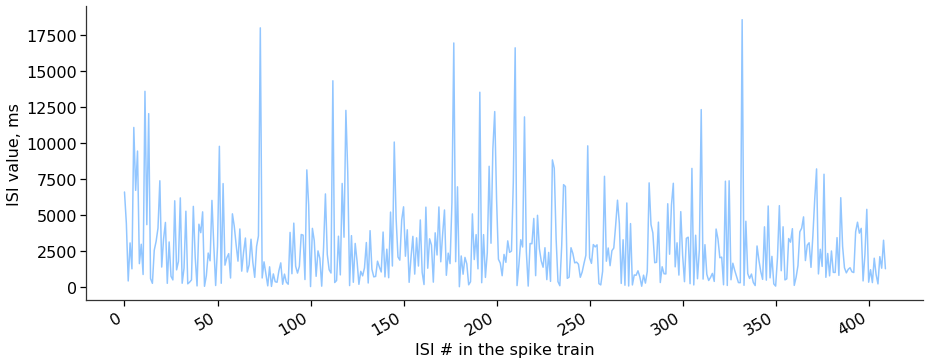

In [18]:
string_to_float = lambda string: [float(value) for value in string.split(',')]
train = string_to_float(X_train.series.values[0])

p.plot(train[:1000])
mpladeq.prettify((15, 6))
p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

In [19]:
def prepare_tsfresh_data(X, y):
    """Extract and preprocess tsfresh features from spiking data"""
    normalizer = TrainNormalizeTransform(window=50, step=50, n_samples=1000)
    X, y = normalizer.transform(X, y, delimiter=',')
    vectorizer = TsfreshVectorizeTransform(feature_set='distribution_features')
    X = vectorizer.transform(X)
    preprocessing_pipeline = TsfreshFeaturePreprocessorPipeline().construct_pipeline()
    X =  preprocessing_pipeline.fit_transform(X)
    return X, y

In [20]:
X_train, y_train = prepare_tsfresh_data(X_train, y_train)
X_test, y_test = prepare_tsfresh_data(X_test, y_test)
X_train, X_test = train_test_common_features(X_train, X_test)

Feature Extraction: 100%|██████████| 40/40 [00:01<00:00, 25.82it/s]


In [21]:
forest = RandomForestClassifier(n_estimators=200,
                                random_state=42,
                                n_jobs=-1)


forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
'AUC-ROC score: {}'.format(roc_auc_score(y_test, forest.predict(X_test)))

'AUC-ROC score: 0.6139726885333311'

In [25]:
importance = pd.DataFrame()
importance['feature'] = X_train.columns.values
importance['importance_score'] = forest.feature_importances_

In [26]:
importance.sort_values(by='importance_score', ascending=False).head(20)

,feature,importance_score
21,value__quantile__q_0.1,0.068087
18,value__quantile__q_0.30000000000000004,0.060425
13,value__quantile__q_0.2,0.060389
14,value__quantile__q_0.9,0.055770
23,value__standard_deviation,0.055022
31,value__variance,0.053394
2,value__quantile__q_0.4,0.047285
5,value__abs_energy,0.046748
27,value__maximum,0.045761
0,value__minimum,0.043463
